# Analysis of the embeddings 


An embedding is a sequence of numbers that represents the concepts within content such as natural language or code. Embeddings make it easy for machine learning models and other algorithms to understand the relationships between content and to perform tasks like clustering or retrieval. 

In [53]:
# Libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from openai import OpenAI
from sklearn.decomposition import PCA
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
)

In [54]:
# Define the embedding model
EMBEDDING_MODEL = "text-embedding-3-large"

## 1. Exploratory Data Analysis

In [55]:
# Import the data
df = pd.read_csv("sentence.csv", sep=",")
df

,categorie,description
0,Python,Python est un langage de programmation interpr...
1,Python,Les développeurs utilisent souvent Python pour...
2,Python,La syntaxe claire et concise de Python en fait...
3,Python,Python est un langage polyvalent utilisé dans ...
4,Python,Les grandes entreprises telles que Google Face...
5,Python,Les listes en Python sont des structures de do...
6,Animaux,Le python royal est une espèce de serpent non ...
7,Animaux,Les pandas géants sont célèbres pour leur pela...
8,Animaux,Les pythons peuvent avaler des proies entières...
9,Animaux,Les pandas roux bien que moins connus que les ...


In [56]:
# Get the list of categories
categories = sorted(df["categorie"].unique())
categories

['Animaux', 'Python']

In [57]:
# Function to create the embeddings
client = OpenAI()

def get_embeddings(text, model=EMBEDDING_MODEL):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], 
model=model).data[0].embedding

In [58]:
# Save embeddings for each question
description_embeddings = []
for description in df["description"]:
    # Get the embeddings
    embedding = get_embeddings(description, model=EMBEDDING_MODEL)
    description_embeddings.append(embedding)
    """
    print(description)
    print(embedding)
    print("\n")
    """
df["description_embedding"] = description_embeddings

# Get the dimension of the embeddings
df["embedding_dim"] = df["description_embedding"].apply(lambda x: len(x))

# Get the norm of the embeddings
df["embedding_norm"] = df["description_embedding"].apply(lambda x: np.linalg.norm(x))
df.head(3)

,categorie,description,description_embedding,embedding_dim,embedding_norm
0,Python,Python est un langage de programmation interpr...,"[-0.019810084253549576, 0.0003318125382065773,...",3072,1.0
1,Python,Les développeurs utilisent souvent Python pour...,"[-0.016582222655415535, -0.016995301470160484,...",3072,1.0
2,Python,La syntaxe claire et concise de Python en fait...,"[0.011798487976193428, 0.0072993808425962925, ...",3072,1.0


We notice that the dimension of the embeddings is 3072, that is coherent with the embedding model used to generate the embeddings.

Additionnally, the norm is 1 for all the embeddings, which means that the embeddings are normalized. This is a common practice in machine learning to normalize the embeddings to make the training process easier.

In [59]:
# Reduce the dimension of the embeddings with PCA
pca_embeddings = PCA(n_components=3).fit_transform(description_embeddings)
df["description_embedding_pca"] = list(pca_embeddings)

# Get the dimension of the embeddings
df["embedding_dim_pca"] = df["description_embedding_pca"].apply(lambda x: len(x))

# Get the norm of the embeddings
df["embedding_norm_pca"] = df["description_embedding_pca"].apply(lambda x: np.linalg.norm(x))
df.head(3)

,categorie,description,description_embedding,embedding_dim,embedding_norm,description_embedding_pca,embedding_dim_pca,embedding_norm_pca
0,Python,Python est un langage de programmation interpr...,"[-0.019810084253549576, 0.0003318125382065773,...",3072,1.0,"[-0.4664758252728602, 0.00847796440769039, -0....",3,0.534030
1,Python,Les développeurs utilisent souvent Python pour...,"[-0.016582222655415535, -0.016995301470160484,...",3072,1.0,"[-0.3061859957008855, -0.2548099921836301, 0.2...",3,0.471001
2,Python,La syntaxe claire et concise de Python en fait...,"[0.011798487976193428, 0.0072993808425962925, ...",3072,1.0,"[-0.31224150731607236, -0.04791677968425453, -...",3,0.323684


After the reduction of the dimensionality, the dimension is 3 and the norm is not 1 anymore. This is because the reduction of the dimensionality is not a linear transformation and the norm is not preserved.

### Embedding Projection After Dimensionality Reduction

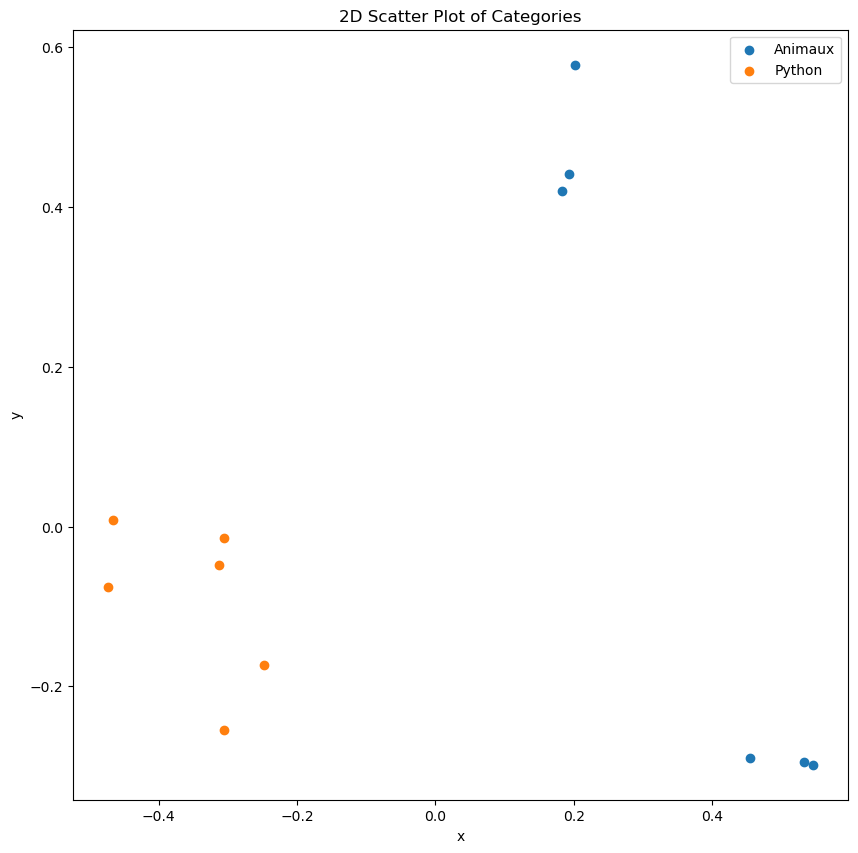

In [60]:
# Display the 2D scatter plot of Categories using Matplotlib
fig = plt.figure(figsize=(10, 10))

for category in categories:
    plt.scatter(df[df["categorie"] == category]["description_embedding_pca"].apply(lambda x: x[0]), 
                df[df["categorie"] == category]["description_embedding_pca"].apply(lambda x: x[1]), 
                label=category)
    
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Scatter Plot of Categories")
plt.legend()
plt.show()

In [61]:
# Display the 2D scatter plot of Categories using Plotly
fig = go.Figure()

for i, cat in enumerate(categories):
    sub_matrix = np.array(df[df["categorie"] == cat]["description_embedding_pca"].to_list())
    x = sub_matrix[:, 0] # first dimension of the embeddings
    y = sub_matrix[:, 1] # second dimension of the embeddings

    # get the question text for hover
    hover_text = df[df["categorie"] == cat]["description"]

    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode="markers",
            marker=dict(size=8, color=i, colorscale="Viridis", opacity=0.8),
            name=cat,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="2D Scatter Plot of Categories",
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=10),
    xaxis=dict(title="x"),
    yaxis=dict(title="y"),
)

fig.show()

In [62]:
# Display the 3D Scatter Plot of Categories
fig = go.Figure()

for i, cat in enumerate(categories):
    sub_matrix = np.array(df[df["categorie"] == cat]["description_embedding_pca"].to_list())
    x = sub_matrix[:, 0]
    y = sub_matrix[:, 1]
    z = sub_matrix[:, 2]

    # get the question text for hover
    hover_text = df[df["categorie"] == cat]["description"]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(size=5, color=i, colorscale="Viridis", opacity=0.8),
            name=cat,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="3D Scatter Plot of Categories",
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=10),
    scene=dict(
        xaxis=dict(title="x"),
        yaxis=dict(title="y"),
        zaxis=dict(title="z"),
    ),
)

fig.show()

## 2. Application in python courses

In [63]:
# Define chapters file names
chapters = [
    "03_affichage.md",
    "04_listes.md",
    "09_fonctions.md",
    "18_jupyter.md"
]

# Define path to the chapters
path = "/home/essmay/Bureau/biopyassistant-sandbox/data/markdown_raw/"

The problematic is : **Can we correctly separate the chunks of these 4 chapters or are they a bit mixed up?**

In [64]:
# Get the content of the chapters
chapter_content = {}

for chapter in chapters:
    with open(path+chapter, 'r') as file:
        lines = file.readlines()
        key = lines[0].lstrip('#').strip()
        value = ''.join(lines[1:])
        chapter_content[key] = value

chapter_content.keys()

dict_keys(['Affichage', 'Listes', 'Fonctions', 'Jupyter et ses notebooks'])

In [65]:
# Split content into chunks
def split_text(text: str, chunk_size: int, chunk_overlap: int) -> list[str]:
    """"
    Split the text into chunks of the specified size and overlap

    Parameters
    ----------
    text : str
        The text to split into chunks
    chunk_size : int
        The size of each chunk
    chunk_overlap : int
        The overlap between each chunk
    
    Returns
    -------
    chunks : list[str]
        A list of text chunks

    """
    # Create a character-based text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        # split on paragraphs, sentences
        separators=["\n\n", "\n"],
    )
    # Split the resulting chunks further based on character limits
    chunks = text_splitter.split_text(text)

    return chunks

In [66]:
# Split the content of the chapters
chapter_chunks = {}
for chapter, content in chapter_content.items():
    chunks = split_text(content, chunk_size=1000, chunk_overlap=200)
    chapter_chunks[chapter] = chunks

for chapter, chunks in chapter_chunks.items():
    print(f"Chapter: {chapter}")
    print(f"Number of Chunks: {len(chunks)}")
    print("\n")

Chapter: Affichage
Number of Chunks: 30


Chapter: Listes
Number of Chunks: 14


Chapter: Fonctions
Number of Chunks: 33


Chapter: Jupyter et ses notebooks
Number of Chunks: 14




In [70]:
# Save the chunks into a CSV file
chunks_df = pd.DataFrame(columns=["chapter", "chunk_content"])
for chapter, chunks in chapter_chunks.items():
    for chunk in chunks:
        chunks_df = pd.concat([chunks_df, pd.DataFrame({"chapter": [chapter], "chunk_content": [chunk]})], ignore_index=True)
chunks_df.to_csv("chapter_chunks.csv", sep=",", index=False)

In [71]:
# Import the data
df_chapter = pd.read_csv("chapter_chunks.csv", sep=",")
df_chapter.head(3)

,chapter,chunk_content
0,Affichage,## La fonction `print()`\n\nDans le chapitre 1...
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est qu..."
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> p..."


In [72]:
# Get the list of chapters
chapters_list = sorted(df_chapter["chapter"].unique())
chapters_list

['Affichage', 'Fonctions', 'Jupyter et ses notebooks', 'Listes']

In [73]:
# Save embeddings for chunk content
chunk_embeddings = []
for content in df_chapter["chunk_content"]:
    # Get the embeddings
    embedding = get_embeddings(content, model=EMBEDDING_MODEL)
    chunk_embeddings.append(embedding)
    """
    print(question)
    print(embedding)
    print("\n")
    """
df_chapter["chunk_content_embedding"] = chunk_embeddings

# Get the dimension of the embeddings
df_chapter["embedding_dim"] = df_chapter["chunk_content_embedding"].apply(lambda x: len(x))

# Get the norm of the embeddings
df_chapter["embedding_norm"] = df_chapter["chunk_content_embedding"].apply(lambda x: np.linalg.norm(x))
df_chapter.head(3)

,chapter,chunk_content,chunk_content_embedding,embedding_dim,embedding_norm
0,Affichage,## La fonction `print()`\n\nDans le chapitre 1...,"[0.024151073768734932, -0.002145542996004224, ...",3072,1.0
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est qu...","[0.01992386393249035, -0.002284943126142025, -...",3072,1.0
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> p...","[0.04030650854110718, -0.003571462817490101, -...",3072,1.0


In [74]:
# Reduce the dimension of the embeddings with PCA
pca_chapter_embeddings = PCA(n_components=3).fit_transform(chunk_embeddings)
df_chapter["chunk_embedding_pca"] = list(pca_chapter_embeddings)

# Get the dimension of the embeddings
df_chapter["chunk_embedding_dim_pca"] = df_chapter["chunk_embedding_pca"].apply(lambda x: len(x))

# Get the norm of the embeddings
df_chapter["chunk_embedding_norm_pca"] = df_chapter["chunk_embedding_pca"].apply(lambda x: np.linalg.norm(x))
df_chapter.head(3)

,chapter,chunk_content,chunk_content_embedding,embedding_dim,embedding_norm,chunk_embedding_pca,chunk_embedding_dim_pca,chunk_embedding_norm_pca
0,Affichage,## La fonction `print()`\n\nDans le chapitre 1...,"[0.024151073768734932, -0.002145542996004224, ...",3072,1.0,"[0.016274999428092553, -0.06715714614512844, -...",3,0.106292
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est qu...","[0.01992386393249035, -0.002284943126142025, -...",3072,1.0,"[0.13792298741709383, -0.05717872502410425, 0....",3,0.153301
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> p...","[0.04030650854110718, -0.003571462817490101, -...",3072,1.0,"[0.17470485750988488, -0.04909702102291303, 0....",3,0.189663


### Embedding Projection After Dimensionality Reduction

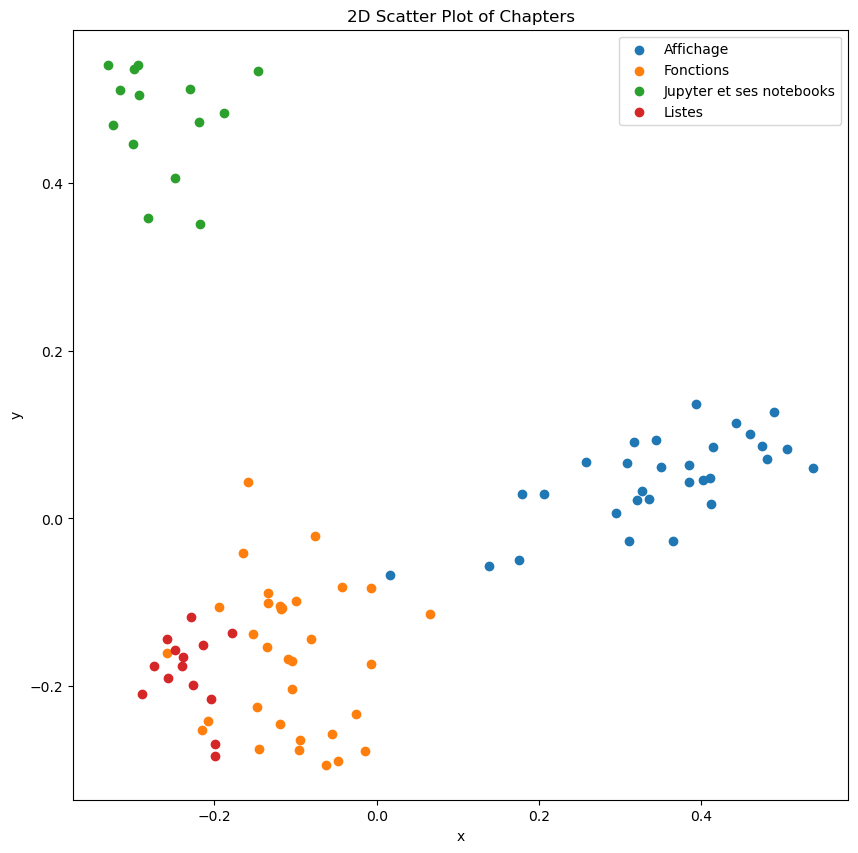

In [75]:
# Display the 2D scatter plot of Categories using Matplotlib
fig = plt.figure(figsize=(10, 10))

for chapter in chapters_list:
    plt.scatter(df_chapter[df_chapter["chapter"] == chapter]["chunk_embedding_pca"].apply(lambda x: x[0]), 
                df_chapter[df_chapter["chapter"] == chapter]["chunk_embedding_pca"].apply(lambda x: x[1]), 
                label=chapter)
    
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Scatter Plot of Chapters")
plt.legend()
plt.show()

In [76]:
# Display the 2D scatter plot of Categories using Plotly
fig = go.Figure()

for i, chapter in enumerate(chapters_list):
    sub_matrix = np.array(df_chapter[df_chapter["chapter"] == chapter]["chunk_embedding_pca"].to_list())
    x = sub_matrix[:, 0] # first dimension of the embeddings
    y = sub_matrix[:, 1] # second dimension of the embeddings

    # get the question text for hover
    hover_text = df_chapter[df_chapter["chapter"] == chapter]["chunk_content"]

    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode="markers",
            marker=dict(size=8, color=i, colorscale="Viridis", opacity=0.8),
            name=chapter,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="2D Scatter Plot of Chapters",
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=10),
    xaxis=dict(title="x"),
    yaxis=dict(title="y"),
)

fig.show()

In [77]:
# Display the 3D Scatter Plot of Categories
fig = go.Figure()

for i, chapter in enumerate(chapters_list):
    sub_matrix = np.array(df_chapter[df_chapter["chapter"] == chapter]["chunk_embedding_pca"].to_list())
    x = sub_matrix[:, 0]
    y = sub_matrix[:, 1]
    z = sub_matrix[:, 2]

    # get the question text for hover
    hover_text = df_chapter[df_chapter["chapter"] == chapter]["chunk_content"]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(size=5, color=i, colorscale="Viridis", opacity=0.8),
            name=chapter,
            hovertext=hover_text,
            hoverinfo="text",
        )
    )

fig.update_layout(
    autosize=False,
    title="3D Scatter Plot of Chapters",
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=10),
    scene=dict(
        xaxis=dict(title="x"),
        yaxis=dict(title="y"),
        zaxis=dict(title="z"),
    ),
)

fig.show()